# DALL-E Mini Inference

# Step 1 - Import the Model

In [2]:
import jax
import jax.numpy as jnp

# Model and tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

from flax.jax_utils import replicate
from functools import partial
import random

In [3]:
# check how many devices are available
jax.local_device_count()

2

In [4]:
# dalle-mini
DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"
DALLE_COMMIT_ID = None

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:0


In [5]:
# Create processor
processor = DalleBartProcessor.from_pretrained(DALLE_MODEL,
                                               revision=DALLE_COMMIT_ID)


wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:0


## Step 2. Setup for Parallel Processing

In [6]:
# Replicate
params = replicate(params)
vqgan_params = replicate(vqgan_params)

## Helper Functions

In [7]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch",
         static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )

# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

# Predict on Prompts

In [10]:
def tokenize_repl_prompts(prompts):
    tokenized_prompts = processor(prompts)
    tokenized_prompt = replicate(tokenized_prompts)
    return tokenized_prompt

In [49]:
from tqdm.notebook import trange
from flax.training.common_utils import shard_prng_key
import numpy as np

def generate_images(prompts,
                    vqgan_params,
                    n_predictions = 8,
                    gen_top_k = None,
                    gen_top_p = None,
                    temperature = None,
                    cond_scale = 10.0
):
    tokenized_prompt = tokenize_repl_prompts(prompts)

    # Create Random Key
    seed = random.randint(0, 2**32 - 1)
    key = jax.random.PRNGKey(seed)
    
    images = []
    for i in trange(max(n_predictions // jax.device_count(), 1)):
        # get a new key
        key, subkey = jax.random.split(key)
        # generate images
        encoded_images = p_generate(
            tokenized_prompt,
            shard_prng_key(subkey),
            params,
            gen_top_k,
            gen_top_p,
            temperature,
            cond_scale,
        )
        # remove BOS
        encoded_images = encoded_images.sequences[..., 1:]
        # decode images
        decoded_images = p_decode(encoded_images, vqgan_params)
        decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
        for img in decoded_images:
            if np.isnan(img.max()):
                continue
            images.append(img)
    return images

In [50]:
prompts = ['cowboy eating pizza on the moon',
           'statue of liberty made out of cheese'
]

In [51]:
imgs = generate_images(prompts, vqgan_params)

  0%|          | 0/4 [00:00<?, ?it/s]

## Display out Output

In [24]:
import matplotlib.pyplot as plt

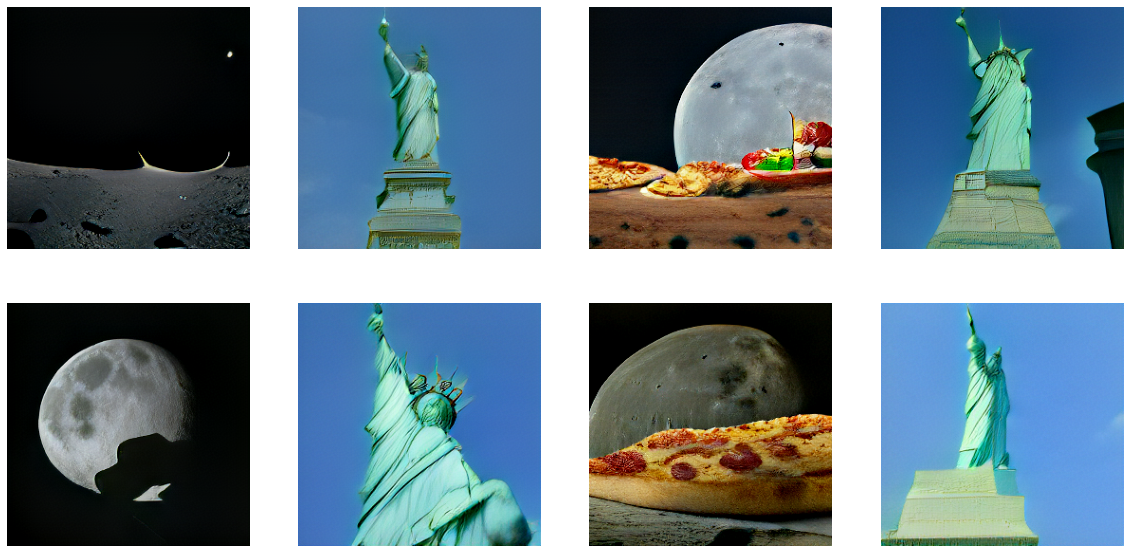

In [62]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for idx, img in enumerate(imgs):
    axs[idx].imshow(img)
    axs[idx].axis('off')

## Test out examples from Dalle2

  0%|          | 0/4 [00:00<?, ?it/s]

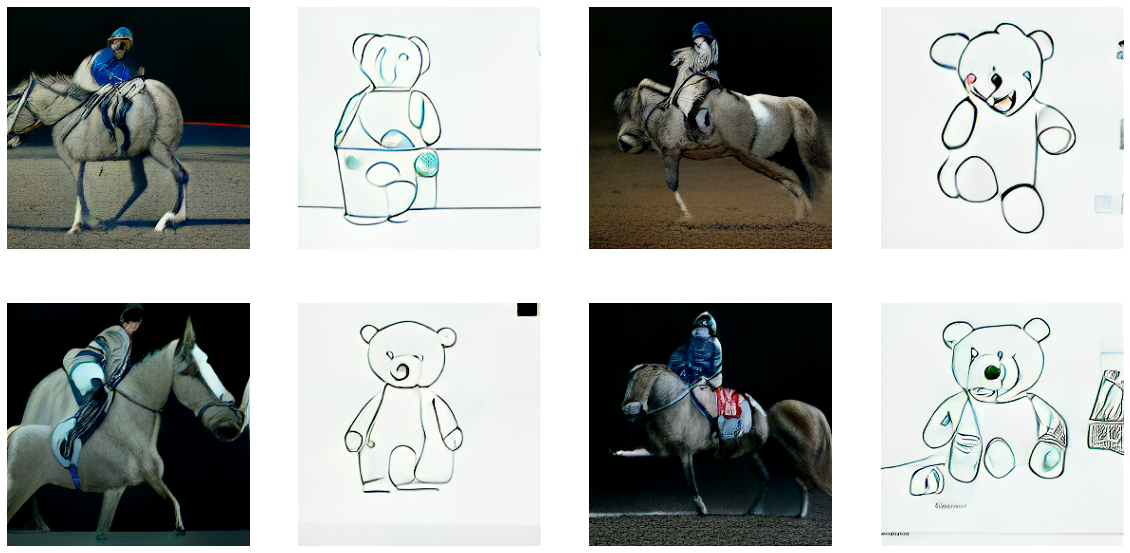

In [64]:
prompts = ['an astronaut riding a horse in photorealistic style',
           'teddy bears shopping for groceries as a one-line drawing'
]

imgs = generate_images(prompts, vqgan_params)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for idx, img in enumerate(imgs):
    axs[idx].imshow(img)
    axs[idx].axis('off')